### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(54321)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [3]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


### Load Data

In [4]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


### Missing values

In [6]:
data[data.loc[:,'inc_angle'] == "na"].count()

band_1        133
band_2        133
id            133
inc_angle     133
is_iceberg    133
dtype: int64

In [7]:
data.loc[data[data.loc[:,'inc_angle'] == "na"].index,'inc_angle'] = 39

In [8]:
train_df = data

In [9]:
train_df['inc_angle'][train_df['inc_angle'] == 39].count()
train_df['inc_angle_f'] = train_df['inc_angle'].astype(np.float)

### Transform for NN

In [10]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

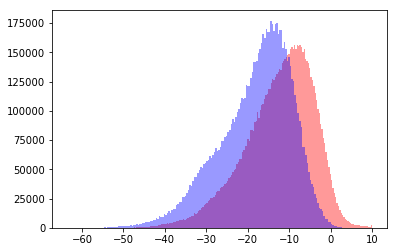

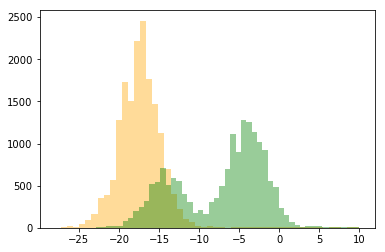

In [11]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

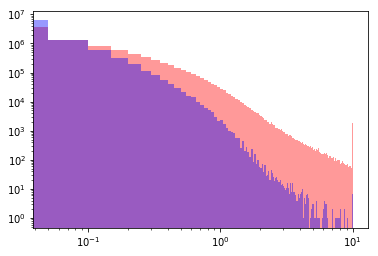

In [12]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

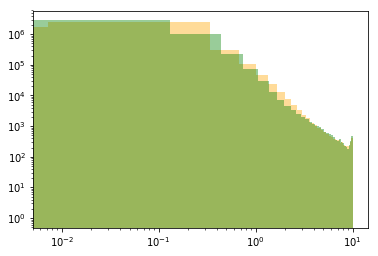

In [13]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [14]:
print(X.max())
print(X.min())
print(X.std())

10.0
-63.464207
9.98626650294


In [15]:
# pre-processing: divide by max and substract mean

#scale = np.max(X_train)
#X_train /= scale

#mean = np.mean(X_train)
#X_train -= mean

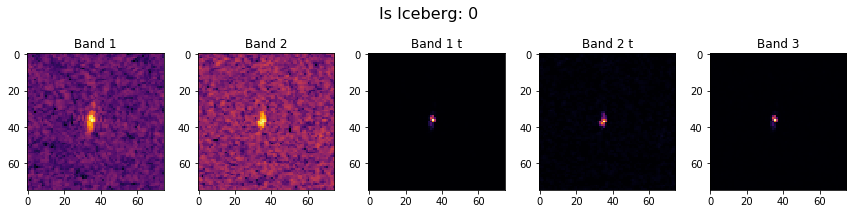

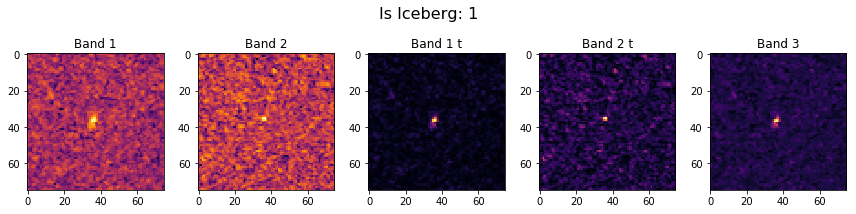

In [16]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [17]:
# = to_categorical(train_df.loc[:,'is_iceberg'], num_classes=2)
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle']]
#y_angle['band_3'] = pd.Series(band_3.tolist()).apply(np.array)

### Split into train test and validation sets

In [18]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)

(1283, 75, 75, 4)
(321, 75, 75, 4)


### Data augmentation

In [19]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3],temp_band_3),axis=3)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)                         
        return [temp_stacked1, temp_stacked2, temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

#flow = datagen.flow(X_train, y_train)
#temp = flow.next()

(1283, 75, 75, 4)


### Keras model

In [20]:
model_code="CNN_2017_12_17_v12"

In [21]:
main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')

#conv layers for main_input
x1 = BatchNormalization()(main_input)
x1 = Conv2D(32, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = Conv2D(32, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2), strides=(2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

#conv layers for aux_input
x2 = BatchNormalization()(aux_input)
x2 = Conv2D(32, (3,3), activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = Conv2D(32, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2), strides=(2, 2))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)

x = Concatenate(axis=3)([x1,x2])
    
    #conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
    #flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
merged = Concatenate()([x, angle_input])

    #dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

    #dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input,angle_input], outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 7.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

file_path = model_path + model_code + ".model_weights.hdf5"

callbacks = get_callbacks(filepath=file_path, patience=10, step_decay=step_decay)

In [22]:
model_f.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 75, 75, 2)     0                                            
____________________________________________________________________________________________________
aux_input (InputLayer)           (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 75, 75, 2)     8           main_input[0][0]                 
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 75, 75, 3)     12          aux_input[0][0]                  
___________________________________________________________________________________________

In [23]:
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=24), validation_steps=len(X_val)/8,
                    #validation_data=[X_val,y_val],
                    epochs=50, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/50
54/53 [==============================] - 25s - loss: 0.7446 - acc: 0.6230 - val_loss: 1.4441 - val_acc: 0.4990
Epoch 2/50
54/53 [==============================] - 22s - loss: 0.5376 - acc: 0.7311 - val_loss: 0.5713 - val_acc: 0.7135
Epoch 3/50
54/53 [==============================] - 21s - loss: 0.4909 - acc: 0.7727 - val_loss: 0.7325 - val_acc: 0.6411
Epoch 4/50
54/53 [==============================] - 21s - loss: 0.4684 - acc: 0.7753 - val_loss: 0.7586 - val_acc: 0.6187
Epoch 5/50
54/53 [==============================] - 21s - loss: 0.4264 - acc: 0.8059 - val_loss: 0.7936 - val_acc: 0.6475
Epoch 6/50
54/53 [==============================] - 22s - loss: 0.4313 - acc: 0.7943 - val_loss: 0.4864 - val_acc: 0.7636
Epoch 7/50
54/53 [==============================] - 22s - loss: 0.4255 - acc: 0.8067 - val_loss: 0.4029 - val_acc: 0.8009
Setting learning rate:  0.00066
Epoch 8/50
54/53 [==============================] - 21s - loss: 0.3814 - acc: 0.8331

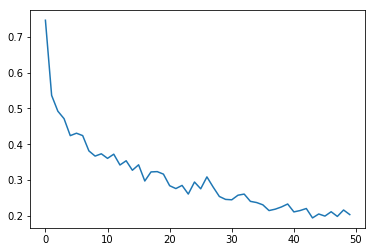

In [24]:
plt.plot(H.history['loss'])
plt.show()

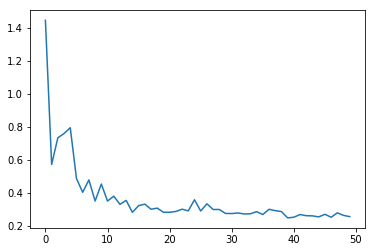

In [25]:
plt.plot(H.history['val_loss'])
plt.show()

In [26]:
callbacks = get_callbacks(filepath=file_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=32),
                    steps_per_epoch=len(X_train_sample)/32,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=32), validation_steps=len(X_val)/8,
                    #validation_data=[X_val,y_val],
                    epochs=14, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/14
41/40 [==============================] - 23s - loss: 0.1780 - acc: 0.9314 - val_loss: 0.2628 - val_acc: 0.8925
Epoch 2/14
41/40 [==============================] - 20s - loss: 0.1963 - acc: 0.9170 - val_loss: 0.2718 - val_acc: 0.8923
Epoch 3/14
41/40 [==============================] - 20s - loss: 0.1854 - acc: 0.9215 - val_loss: 0.2656 - val_acc: 0.8906
Epoch 4/14
41/40 [==============================] - 21s - loss: 0.1854 - acc: 0.9230 - val_loss: 0.2590 - val_acc: 0.8973
Epoch 5/14
41/40 [==============================] - 20s - loss: 0.1939 - acc: 0.9158 - val_loss: 0.2659 - val_acc: 0.8880
Epoch 6/14
41/40 [==============================] - 21s - loss: 0.1760 - acc: 0.9352 - val_loss: 0.2671 - val_acc: 0.8942
Epoch 7/14
41/40 [==============================] - 20s - loss: 0.1782 - acc: 0.9257 - val_loss: 0.2752 - val_acc: 0.8880
Setting learning rate:  6.6e-07
Epoch 8/14
41/40 [==============================] - 20s - loss: 0.1607 - acc: 0.9367

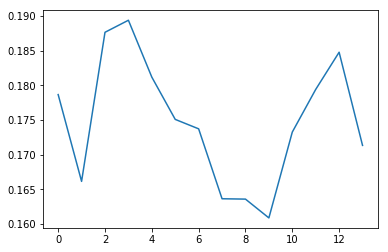

In [27]:
plt.plot(H.history['loss'])
plt.show()

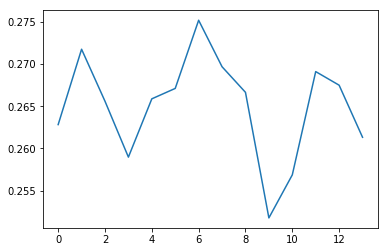

In [28]:
plt.plot(H.history['val_loss'])
plt.show()

In [29]:
model_f.save_weights(model_path + model_code +'.model.pkl')

In [30]:
model_f.load_weights(model_path + model_code + '.model_weights.hdf5')

In [31]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 3 input arrays, but only received one array. Found: array with shape (321, 75, 75, 4)

In [ ]:
test_df = pd.read_json("Data/test/test.json")

In [ ]:
test_df.head()

In [ ]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

In [ ]:
predictions = model.predict(X_test,verbose=1, batch_size=64)

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions.reshape(-1)})
submission.head()

In [ ]:
submission.to_csv("submission.v7.csv", index=False)